# Genres and modularity

Modularity describes the structure of a network. It can be used to measure how strongly a network is divided into communities.
High modularity implies that the communities in the network is dense, while the connections between communities are sparse.

-- Genres

In [212]:
import networkx as nx
import numpy as np
import requests
import matplotlib.pyplot as plt
from collections import Counter
from io import BytesIO
import re
from collections import defaultdict
import random
import pandas as pd


url = "https://raw.githubusercontent.com/fridapfrandsen/network-data/main/rock_network.gexf"

response = requests.get(url)
response.raise_for_status()

G = nx.read_gexf(BytesIO(response.content))

Getting the undirected grahp and removing nodes without genre information

In [213]:
G = G.to_undirected()

nodes_without_genre = [node for node, data in G.nodes(data=True) if "genres" not in data or not data["genres"]]

G.remove_nodes_from(nodes_without_genre)

## Genres

Partitioning the network using the genres

In [214]:
genre_part = {}
for n, data in G.nodes(data=True):
    genres = data.get("genres")
    if not genres:
        continue
    if isinstance(genres, str):
        cleaned = re.sub(r"[\*\n\r\t]+", " ", genres.lower())
        parts = re.split(r",|;|\s{2,}", cleaned)
        genres = [p.strip() for p in parts if p.strip()]

    elif isinstance(genres, (list, set, tuple)):
        genres = [g.strip().lower() for g in genres if g.strip()]

    if genres:
        genre_part[n] = genres[0]

# Splitting into communities

genre_comm = defaultdict(list)
for node, genre in genre_part.items():
    genre_comm[genre].append(node)

Computing modularity

In [215]:
# Function to calculate modularity
def Modularity(G, partition):
    if isinstance(partition, dict):
        communities = list(partition.values())
    else:
        communities = partition
    M = 0
    L = G.number_of_edges()
    deg = dict(G.degree())
    for nodes in communities:
        subG = G.subgraph(nodes)
        L_c = subG.number_of_edges()
        k_c = sum(deg[n] for n in nodes)
        M += (L_c / L) - (k_c / (2 * L)) ** 2
    return M

In [216]:
# Calculating number of links and nodes in each community and finding the sum
M = Modularity(G, genre_comm)

print(f"Modularity (manual calc): {M:.4f}")

# Checking that we calculated the modularity correct by comparing with networkx 
from networkx.algorithms.community.quality import modularity
M_check = modularity(G, list(genre_comm.values()))
print(f"Modularity (networkx calc): {M_check:.4f}")

Modularity (manual calc): 0.0985
Modularity (networkx calc): 0.0985


The modularity is 0.0985, meaning that the partitioning of the network into the first genre on the list of genres, don't give a clear community structure.

Instead we try to divide after a random genre on the artist's list:

In [217]:
genre_part_random = {}
for n, data in G.nodes(data=True):
    genres = data.get("genres")
    if not genres:
        continue
    if isinstance(genres, str):
        cleaned = re.sub(r"[\*\n\r\t]+", " ", genres.lower())
        parts = re.split(r",|;|\s{2,}", cleaned)
        genres = [p.strip() for p in parts if p.strip()]

    elif isinstance(genres, (list, set, tuple)):
        genres = [g.strip().lower() for g in genres if g.strip()]

    if genres:
        genre_part_random[n] = random.choice(genres)


# Splitting into communities
genre_comm_random = defaultdict(list)
for node, genre in genre_part_random.items():
    genre_comm_random[genre].append(node)

M_random = Modularity(G, genre_comm_random)


# --- Udskriv sammenligning ---
print(f"Modularity (first genre):  {M:.4f}")
print(f"Modularity (random genre): {M_random:.4f}")

Modularity (first genre):  0.0985
Modularity (random genre): 0.0351


It turns out the modularity is actually lower when we partition using a random genre instead. This is because we decrease the big hub that is the "rock" community. 

Both partitionings is so close to zero, that they resemble a random network.

## Communities

Using the Louvain algortihm to partition the network into communities

In [218]:
from networkx.algorithms.community import louvain_communities

louv_comm = louvain_communities(G, seed=42)

print(f"Number of communities: {len(louv_comm)}")


Number of communities: 7


Computing the modularity

In [219]:
M_louvain = Modularity(G, louv_comm)

print(f"Modularity (Louvain communities): {M_louvain:.4f}")

Modularity (Louvain communities): 0.3257


We see that the modularity is much higher using the Louvain algorithm for partitioning.
In this partitioning, we actually detect real networks.

It could imply that the communities doesn't depend on the genre, but perhaps on other factors, such as the years tha rtist was active or the country they're from.

## Communities vs. genres

Computing the confusion matrix D

In [220]:
# Top 7 genres
all_genres = []
for _, data in G.nodes(data=True):
    genres = data.get("genres")
    if isinstance(genres, str):
        genres = [g.strip().lower().replace("*", "") for g in genres.split(",") if g.strip()]
    if genres:
        all_genres.extend(genres)

# Biggest 7 communites
communities = sorted(louv_comm, key=len, reverse=True)
top_comms = communities[:7]

top_genres = [g for g, _ in Counter(all_genres).most_common(7)]
print("Top genres:", top_genres)
print("Top community sizes:", [len(c) for c in top_comms])

node_to_comm = {}
for j, comm in enumerate(top_comms):
    for n in comm:
        node_to_comm[n] = j

matrix = pd.DataFrame(0, index=top_genres, columns=[f"C{j}" for j in range(len(top_comms))])

for n, data in G.nodes(data=True):
    if n not in node_to_comm:
        continue 
    genres = data.get("genres")
    if isinstance(genres, str):
        genres = [g.strip().lower().replace("*", "") for g in genres.split(",") if g.strip()]
    if not genres:
        continue
    for g in genres:
        if g in top_genres:
            matrix.loc[g, f"C{node_to_comm[n]}"] += 1

display(matrix)

Top genres: ['rock', 'hard rock', 'pop rock', 'alternative rock', 'blues rock', 'soft rock', 'pop']
Top community sizes: [130, 99, 89, 82, 69, 4, 1]


,C0,C1,C2,C3,C4,C5,C6
rock,34,0,15,6,0,0,1
hard rock,6,2,21,4,6,0,0
pop rock,10,1,15,10,2,0,0
alternative rock,2,2,1,17,9,0,0
blues rock,10,1,12,1,1,0,0
soft rock,11,0,11,2,0,0,0
pop,16,0,5,0,0,0,0


The confusion matrix show us that the correlation between the communities and the genres are not the big. Although there is some overlap, since the diagonol in the matrix has some of the higher numbers.

## Plot of the communities

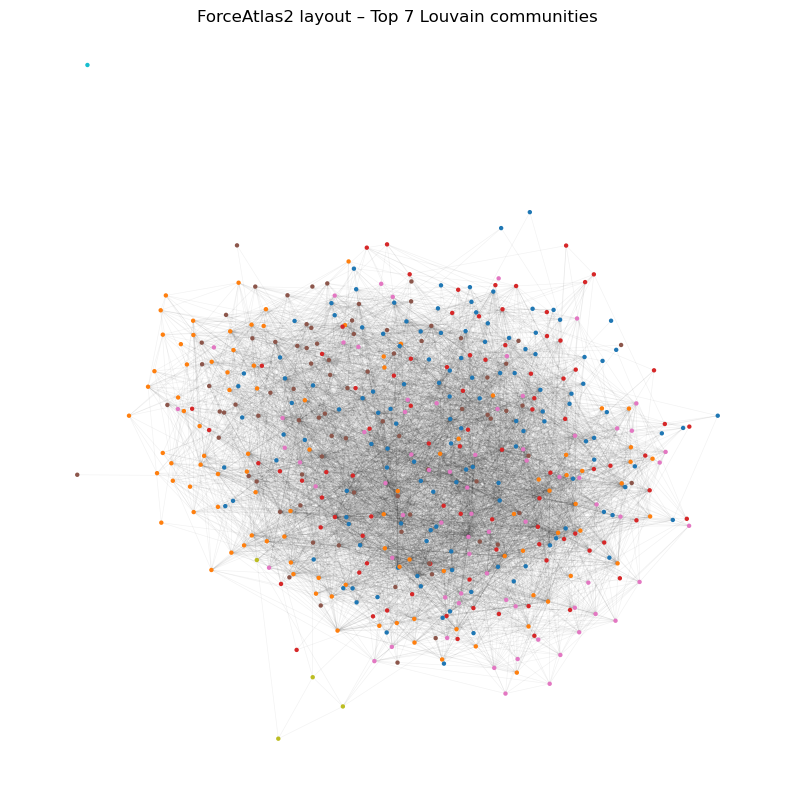

In [221]:
pos = nx.forceatlas2_layout(
    G
)

communities_sorted = sorted(communities, key=len, reverse=True)
top = communities_sorted[:7]
top_nodes = set().union(*top)

palette = plt.cm.tab10(np.linspace(0, 1, len(top)))
color_map = {}
for i, comm in enumerate(top):
    for node in comm:
        color_map[node] = palette[i]

node_colors = [
    color_map.get(n, (0.85, 0.85, 0.85, 0.4))
    for n in G.nodes()
]

plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color=node_colors, linewidths=0)
plt.axis("off")
plt.title("ForceAtlas2 layout – Top 7 Louvain communities")
plt.show()